In [1]:
import sys
import pandas as pd
import ECAUGT
import time
import multiprocessing
import numpy as np

# set parameters
endpoint = "https://HCAd-Datasets.cn-beijing.ots.aliyuncs.com"
access_id = "LTAI5t7t216W9amUD1crMVos" #enter your id and keys
access_key = "ZJPlUbpLCij5qUPjbsU8GnQHm97IxJ"
instance_name = "HCAd-Datasets"
table_name = 'HCA_d'

ECAUGT.Setup_Client(endpoint, access_id, access_key, instance_name, table_name)

Connected to the server, find the table.
HCA_d
TableName: HCA_d
PrimaryKey: [('cid', 'INTEGER')]
Reserved read throughput: 0
Reserved write throughput: 0
Last increase throughput time: 1605795297
Last decrease throughput time: None
table options's time to live: -1
table options's max version: 1
table options's max_time_deviation: 86400


0

In [4]:
query_language = "cell_type == T cell && organ== Lung && seq_tech==10X"
cid_label = ECAUGT.query_cells(metadata_conditions=query_language, include_children=True)

13519 cells found


In [5]:
query_language  = "CD4<=0"
gene_condition  = ECAUGT.seq2filter(query_language)
df_result_tcell = ECAUGT.get_columnsbycell_para(
                                rows_to_get = cid_label,
                                # make sure condition associated columns listed here
                                cols_to_get=['CD4'],
                                col_filter=gene_condition,
                                do_transfer = False,
                                thread_num = 40
                         )

In [10]:
rows_to_get = [[x[0]] for x in df_result_tcell]

In [11]:
print(len(rows_to_get))

12234


In [27]:
import pickle
pickle.HIGHEST_PROTOCOL
with open('rows_to_get.pickle', 'wb') as f:
    pickle.dump(rows_to_get, f, protocol=4)

In [28]:
result = ECAUGT.get_columnsbycell_para(rows_to_get = rows_to_get,
                                           cols_to_get = None, # download all columns
                                           col_filter  = None,
                                           do_transfer = True,
                                           thread_num  = 40)

In [44]:
result.to_pickle("sorted_tcells_raw.pk")

In [12]:
result = pd.read_pickle('sorted_tcells_raw.pk')

In [13]:
import scanpy as sc
import sys
import pandas as pd
import ECAUGT
import time
import multiprocessing
import numpy as np

In [22]:
# create scanpy object from the matrices
expr = result.iloc[:,:43878]
meta = result.iloc[:,43878:43878+16]
meta.reset_index(inplace=True)
expr.reset_index(inplace=True)
expr.drop(['cid'],axis=1,inplace=True)
adata = sc.AnnData(X = expr, obs = meta)
adata = adata[adata.obs['seq_tech']=='10X',:]
adata.var_names_make_unique()

/home/hms/anaconda3/envs/stagate/lib/python3.6/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
adata

AnnData object with n_obs × n_vars = 12234 × 43878
    obs: 'cid', 'cell_id', 'cell_type', 'cl_name', 'donor_age', 'donor_gender', 'donor_id', 'uHAF_name', 'marker_gene', 'organ', 'original_name', 'region', 'sample_status', 'seq_tech', 'study_id', 'subregion', 'tissue_type'

In [24]:
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_genes(adata, min_cells=3)

In [25]:
adata

AnnData object with n_obs × n_vars = 12234 × 14917
    obs: 'cid', 'cell_id', 'cell_type', 'cl_name', 'donor_age', 'donor_gender', 'donor_id', 'uHAF_name', 'marker_gene', 'organ', 'original_name', 'region', 'sample_status', 'seq_tech', 'study_id', 'subregion', 'tissue_type'
    var: 'n_counts', 'n_cells'

In [26]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

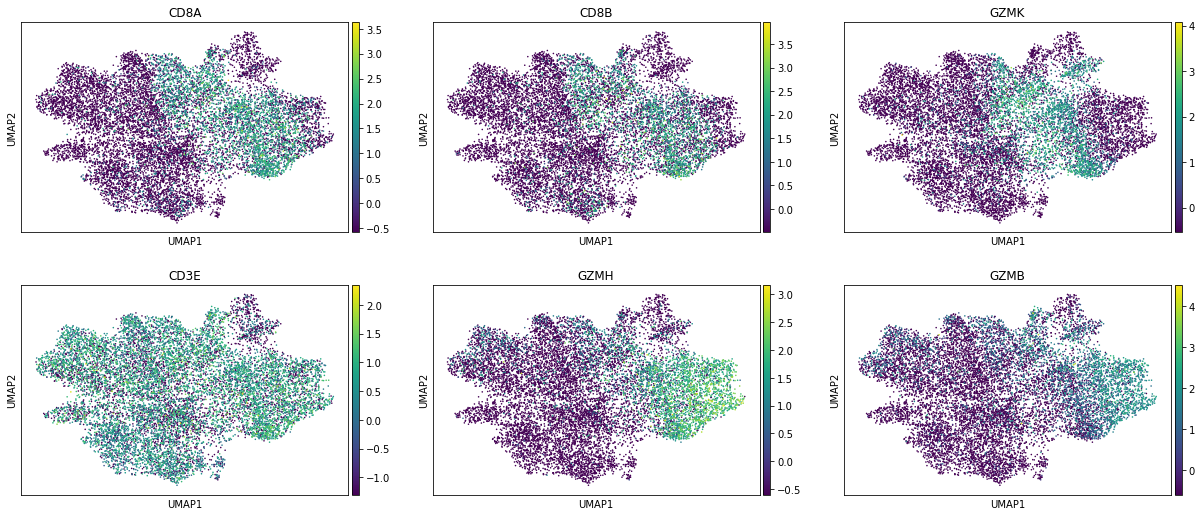

In [29]:
sc.pl.umap(adata,color=['CD8A','CD8B','GZMK','CD3E','GZMH','GZMB'],ncols=3)

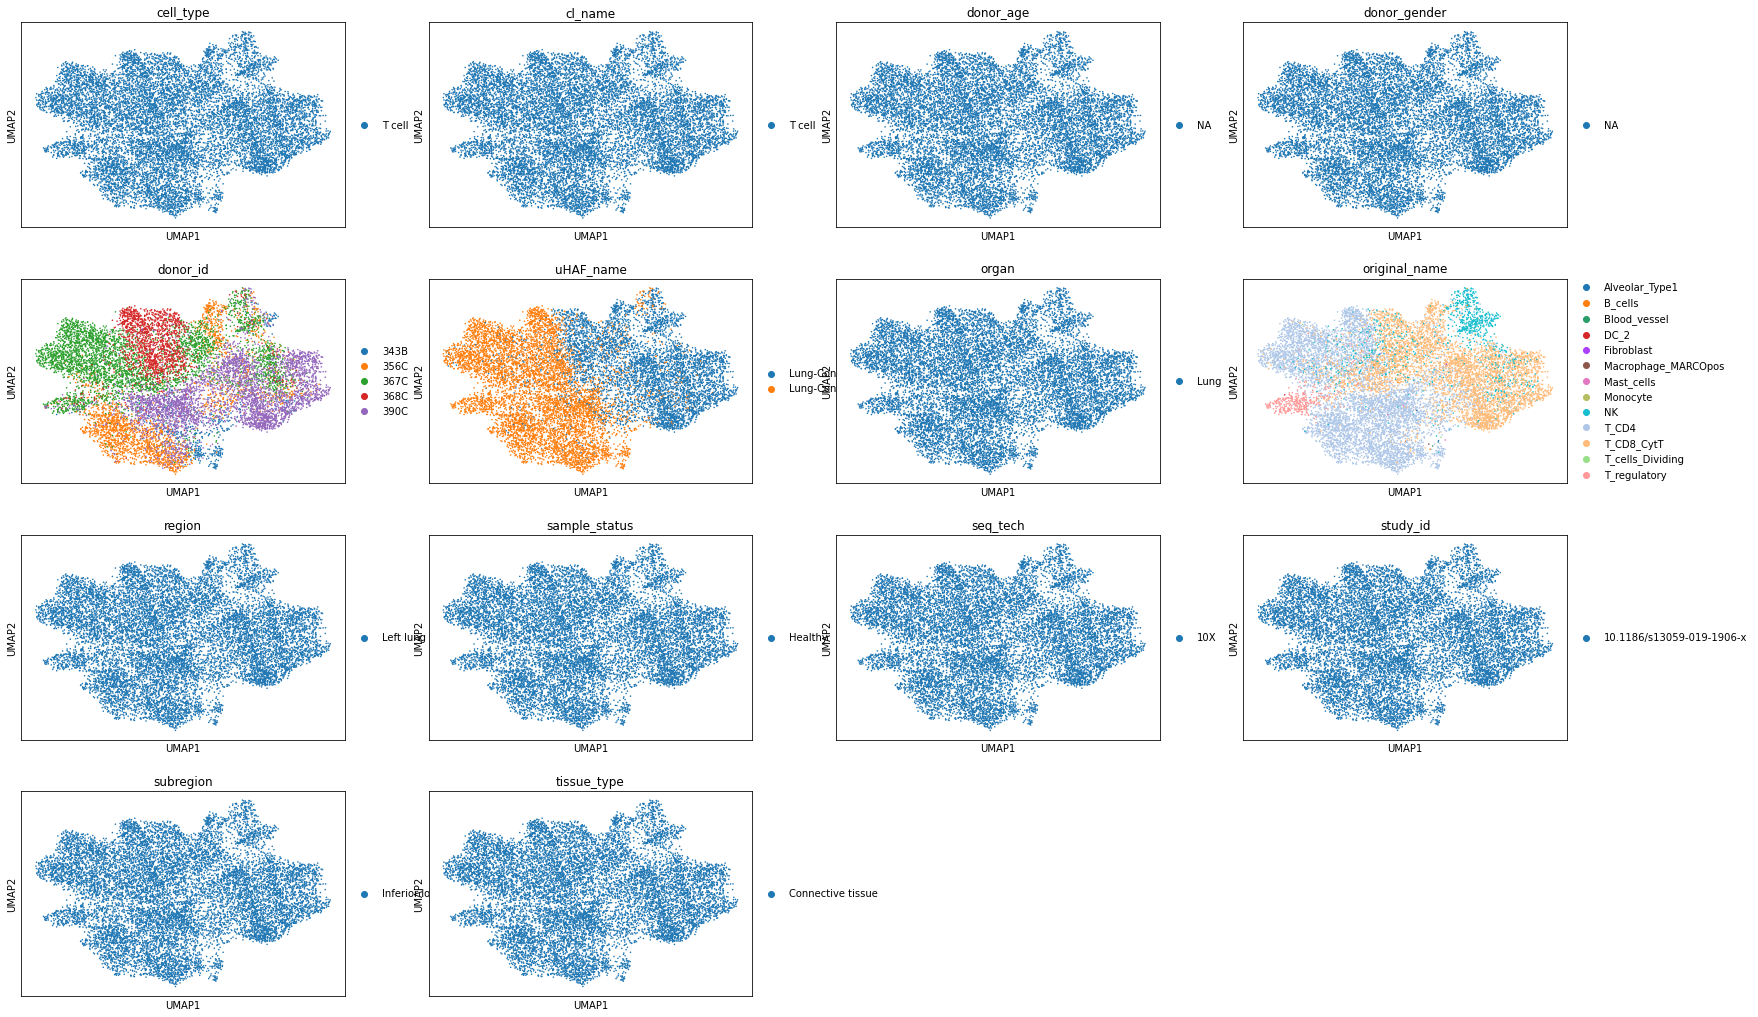

In [30]:
sc.pl.umap(adata,color=['cell_type', 'cl_name', 'donor_age', 'donor_gender', 'donor_id', 'uHAF_name', 'organ', 'original_name', 'region', 'sample_status', 'seq_tech', 'study_id', 'subregion', 'tissue_type']) 